# Lab 4: Building a Spotify Song Classifier with KNNs and Decision Trees
**Classify by genres**. In this lab, you will build machine learning genre classifiers using a dataset of Spotify tracks. Your goal is to train a model that can distinguish between two selected genres based on various audio features such as danceability, energy, valence, tempo, and more.

We'll follow the familiar workflow of data exploration -> preprocessing -> model training -> evaluation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### Step 1: The data
We'll focus on two genres: Blues and Jazz (what’s the difference, anyway??).

Both genres have rich musical histories, but they differ in structure:

- Blues tends to have simpler chord progressions and a strong emotional expression.
- Jazz often involves complex improvisation and more varied rhythms.

But can a machine really tell them apart just by looking at numerical audio features? That’s what we’ll find out!

In this step, you will:
- Load the dataset
- Extract only blues and jazz for classification

In [2]:
# Read Data
spotify_data = pd.read_csv('/courses/EDS232/Data/spotify_dat.csv')

# Look at the first 5 rows
spotify_data.head(5)

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date,genres
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02,rap metal
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02,rap metal
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02,rap metal
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02,rap metal
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02,rap metal


In [3]:
# Print the data types
spotify_data.dtypes

id                   object
name                 object
album                object
album_id             object
artists              object
artist_ids           object
track_number          int64
disc_number           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature      float64
year                  int64
release_date         object
genres               object
dtype: object

In [4]:
# Filter Blues and Jazz genres
blues_data = spotify_data[spotify_data["genres"] == "blues"]
jazz_data = spotify_data[spotify_data["genres"] == "jazz"]

# Verify
print(blues_data["genres"].unique())
print(jazz_data["genres"].unique())

['blues']
['jazz']


In [5]:
# Combine both genres into one dataset
combined_data = pd.concat([blues_data, jazz_data])

# Verify
print(combined_data["genres"].unique())

['blues' 'jazz']


In [6]:
# Rename 'genres' column to 'genre' for clarity
combined_data = combined_data.rename(columns = {"genres" : "genre"})

# Verify
combined_data.columns

Index(['id', 'name', 'album', 'album_id', 'artists', 'artist_ids',
       'track_number', 'disc_number', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'year', 'release_date', 'genre'],
      dtype='object')

## Step 2: Data Exploration
Now that we have Blues and Jazz as our two genres, it's time to explore the data and look for patterns in the audio features.

Let's investigate:
- Which features are available?
- How strongly these features correlate with each other.
- How different genres distribute across  sample features: danceability 

In this step, we will:
- Filter out non-numeric columns before the plotting
- Visualize feature correlations using a heatmap.
- Examine key feature distributions with histograms to see if genres behave differently.


In [7]:
# Exclude non-numeric columns but keep 'genre' for grouping
numeric_features = combined_data.select_dtypes(include = ["int64", "bool", "float64"]).assign(genre = combined_data["genre"])

# Verify
numeric_features.dtypes

track_number          int64
disc_number           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature      float64
year                  int64
genre                object
dtype: object

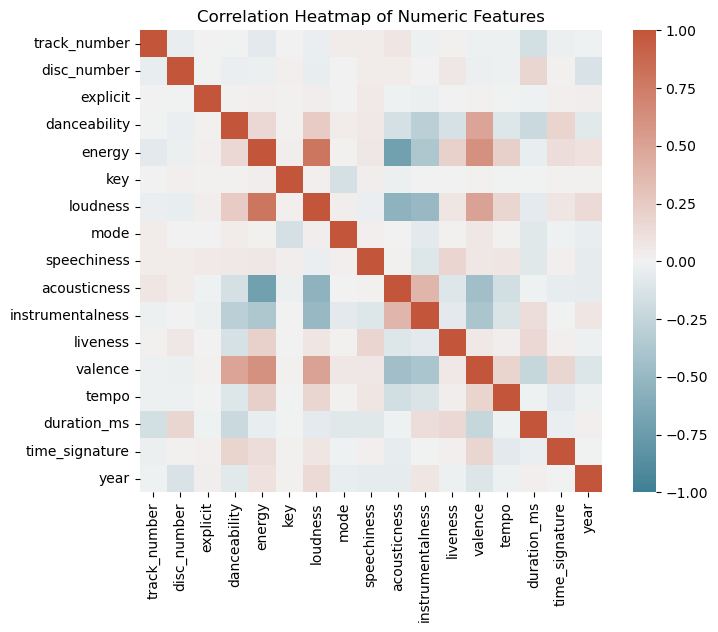

In [8]:
# Correlation heatmap

# Set figure size
plt.figure(figsize = (8, 6))

# Calculate correlation matrix
nf_corr = numeric_features.drop(columns = ["genre"]).corr()

# Plot heatmap
sns.heatmap(nf_corr, 
            vmin = -1, 
            vmax = 1, 
            center = 0,
            cmap = sns.diverging_palette(220, 20, as_cmap = True),
            square = True)

# Add a title
plt.title("Correlation Heatmap of Numeric Features")

# Display plot
plt.show()

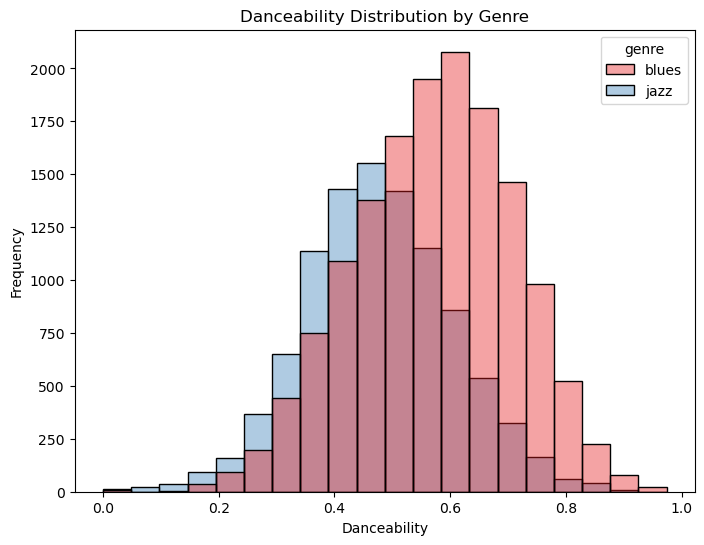

In [9]:
# Histogram of danceability

# Set figure size
plt.figure(figsize = (8, 6))

# Plot histogram with genre-based coloring
sns.histplot(data = combined_data, 
             x = "danceability", 
             hue = "genre",
             bins = 20,
             alpha = 0.4,
             palette = "Set1")

# Add axis labels
plt.xlabel("Danceability")
plt.ylabel("Frequency")

# Add a title
plt.title("Danceability Distribution by Genre")

# Display plot
plt.show()

### Step 3: Check for class imbalance
An unequal distribution between the target classes can cause issues for our classifiers, so we'll need to check for that. A commonly used guideline for class imbalance is:

- Slight Imbalance (Less than 1.5:1) → Generally okay; no need for balancing.
- Moderate Imbalance (Between 1.5:1 and 3:1) → Might cause some bias; balancing can help.
- Severe Imbalance (More than 3:1) → Strongly affects model performance; balancing is usually necessary.

In [10]:
# Print counts of each genre
class_counts = numeric_features["genre"].value_counts()

# Calculate ratio of majority to minority class
class_ratio = max(class_counts) / min(class_counts)

# Print class distribution and ratio
print(class_counts)
print(f"Class Ratio: {class_ratio:.3f}")

genre
blues    14811
jazz     10023
Name: count, dtype: int64
Class Ratio: 1.478


Given this result, should we be worried about the imbalance?

There is approximately a 1.5:1 class ratio between blues and jazz. This slight imbalance is generally acceptable and does not require any balancing.

### Step 4: Preprocessing
We need to ensure all the variables we use are numerical so the models can process them. First we'll drop all the variables that are not numeric or the target. Then we'll use a sklearn utility, `LabelEncoder()` to encode our categorical target variable into numerical values. Print the first five values of your encoded labels.

In [11]:
# Define the features (drop columns that are not numeric or target)
X = numeric_features.drop(columns = "genre")

# Set the target variable as 'genre'
y =  numeric_features["genre"]

# Encode the target variable ('label') using label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print first five values of encoded labels
print(y_encoded[: 5])

[0 0 0 0 0]


Good, now we'll do our data splitting and scaling.  Let's go with an 80/20 split this time.

In [12]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the training set
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test set
X_test_scaled = scaler.transform(X_test)

### Step 5: Train the models
OK, now it's time to build our models and assess the training accuracy. We'll use the default of k = 5 for the KNN model.

In [13]:
# Initialize models
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()

# Train (fit) both models
knn.fit(X_train_scaled, y_train)
dt.fit(X_train_scaled, y_train)

# Predictions on training data
knn_y_train_pred = knn.predict(X_train_scaled)
dt_y_train_pred = dt.predict(X_train_scaled)

# Compute training accuracy 
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)

#Print training accuracy for both models
print(f"KNN Training Accuracy: {knn_train_accuracy:.3f}")
print(f"Decision Tree Training Accuracy: {dt_train_accuracy:.3f}")

KNN Training Accuracy: 0.921
Decision Tree Training Accuracy: 1.000


### Step 6: Evaluate models
OK, now let's go ahead and predict on the test data to see how well our models do at predicting the genre of unseen tracks.

In [14]:
# Make predictions
knn_pred = knn.predict(X_test_scaled)
dt_pred = dt.predict(X_test_scaled)

# Evaluate prediction accuracy
knn_accuracy = accuracy_score(y_test, knn_pred)
dt_accuracy = accuracy_score(y_test, dt_pred)

# Print prediction accuracy for both models
print(f"KNN Prediction Accuracy: {knn_accuracy:.3f}")
print(f"Decision Tree Predction Accuracy: {dt_accuracy:.3f}")

KNN Prediction Accuracy: 0.890
Decision Tree Predction Accuracy: 0.863


### Step 7: Visualizing Model Performance
Now that we have evaluated our models on unseen data, let’s compare their performance by visualizing the training vs. test accuracy.  We'll look for signs of overfitting by plotting the training accuracy and test accuracy for both k-NN and Decision Trees.

Create a bar chart that compares the training accuracy and test accuracy for k-NN and Decision Trees. Your plot should clearly display:

- The training and test accuracy for both models.
- Properly labeled axes and a title.
- A legend to differentiate training and test accuracy.
- Accuracy values displayed on top of each bar.

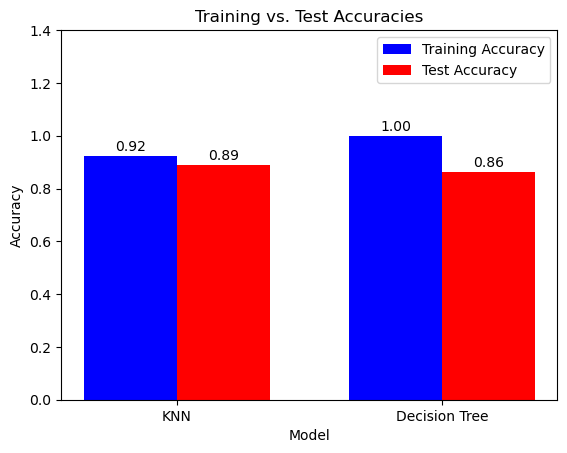

In [15]:
# Create the bar chart

# Combine accuracies
models = ['KNN', 'Decision Tree']
train_accuracies = [knn_train_accuracy, dt_train_accuracy]
test_accuracies = [knn_accuracy, dt_accuracy]

# Set bar width
bar_width = 0.35

# Generate positions on x-axis for bars
indices = np.arange(len(models))

# Create the bar chart
plt.bar(indices - bar_width / 2, 
        train_accuracies, 
        width = bar_width, 
        label = "Training Accuracy", 
        color = "blue")

plt.bar(indices + bar_width / 2, 
        test_accuracies, 
        width = bar_width, 
        label = "Test Accuracy", 
        color = "red")

# Add accuracy values on top of the bars
for i in range(len(models)):
    plt.text(indices[i] - bar_width / 2, train_accuracies[i] + 0.02, f"{train_accuracies[i]:.2f}", ha = "center")
    plt.text(indices[i] + bar_width / 2, test_accuracies[i] + 0.02, f"{test_accuracies[i]:.2f}", ha = "center")
    

# Fix axes
plt.xticks(indices, models)
plt.ylim(0, 1.4)

# Add a title
plt.title("Training vs. Test Accuracies")

# Add axis labels
plt.xlabel("Model")
plt.ylabel("Accuracy")

# Add a legend
plt.legend()

# Display plot
plt.show()

Which model does a better job of generalizing to unseen data? How do you know?
Does it appear that either of the models are overfitting? Why?

The KNN model did a better job generalizing the unseen data because it has a higher test accuracy. The Decision Tree model overfitted the training data, achieving a perfect training accuracy of 100%, which likely resulted in its lower test accuracy. 

### Bonus question
In the workflow above, we used the default parameter values of k = 5 for the KNN model, and maxdepth = None for the Decision Tree. Choose one of the models and see if you can improve test performance by optmizing its corresponding parameter value.

In [16]:
# Tune the model using a function
def decision_tree():
    
    max_depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    accuracies = []
    
    for depth in max_depths:
        dt = DecisionTreeClassifier(max_depth = depth)
        dt.fit(X_train_scaled, y_train)
        
        # Make predictions and calculate accuracy
        y_pred = dt.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        # Print max depth with corresponding accuracy
        print(f"Max Depth {depth} - Accuracy: {accuracy:.3f}")

decision_tree()

Max Depth 2 - Accuracy: 0.817
Max Depth 3 - Accuracy: 0.841
Max Depth 4 - Accuracy: 0.857
Max Depth 5 - Accuracy: 0.870
Max Depth 6 - Accuracy: 0.875
Max Depth 7 - Accuracy: 0.881
Max Depth 8 - Accuracy: 0.881
Max Depth 9 - Accuracy: 0.885
Max Depth 10 - Accuracy: 0.882


I chose to improve the Decision Tree model by tuning the max depth parameter as mentioned above. During the discussion section, Annie taught us how to identify the best-performing tree by evaluating a list of potential max depths with a specific function. This approach allows us to select the max depth that yields the highest accuracy. This method is an example of pre-pruning because it sets limitations on the decision tree before it is constructed.